In [59]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sai14karthik/nasdq-dataset")

# print("Path to dataset files:", path)

# Table of Contents
- [Introduction](#introduction)
- [Import Libraries](#import-libraries)
- [Load and Preprocess the Dataset](#load-and-preprocess-the-dataset)
- [Calculate Technical Indicators](#calculate-technical-indicators)
  - [Relative Strength Index (RSI)](#relative-strength-index-rsi)
  - [Moving Average Convergence Divergence (MACD)](#moving-average-convergence-divergence-macd)
  - [Bollinger Bands](#bollinger-bands)
  - [Moving Averages](#moving-averages)
  - [Stochastic Oscillator](#stochastic-oscillator)
  - [Average True Range (ATR)](#average-true-range-atr)
- [Feature Engineering](#feature-engineering)
  - [Add Lag Features](#add-lag-features)
- [Split Data into Training, Validation, and Test Sets](#split-data-into-training-validation-and-test-sets)
- [Prepare Features](#prepare-features)
- [Hyperparameter Tuning with Grid Search](#hyperparameter-tuning-with-grid-search)
- [Train and Evaluate the Model](#train-and-evaluate-the-model)
  - [Evaluate on Test Set](#evaluate-on-test-set)
- [Save the Model](#save-the-model)
- [Visualizations](#visualizations)
- [Make a Prediction for the Latest Data Point](#make-a-prediction-for-the-latest-data-point)
- [Conclusion](#conclusion)

---

## Introduction

Predicting stock prices is a classic problem in finance. By analyzing historical data and extracting meaningful features, we can build models to forecast future prices. In this notebook, we'll use various technical indicators from finance to capture patterns and trends in the data. 









## Hyperparameter Tuning with Grid Search

## Train and Evaluate the Model
### Evaluate on Test Set

## Save the Model

## Visualizations

## Make a Prediction for the Latest Data Point

## Conclusion


## Import Libraries

In [3]:
!pip install ta

  Using cached ta-0.11.0.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=340f76401b9523f469ee1f6698df8498d9668550f54497e3858e477ce6f6099e
  Stored in directory: /Users/rafalszulinski/Library/Caches/pip/wheels/61/d8/66/8018676d483fa5edb5337a7a25ee8c029ac255be25f90f3cd5
Successfully built ta


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta import momentum, trend, volatility
from ta.momentum import StochasticOscillator
from ta.volatility import AverageTrueRange
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
import pickle
%matplotlib inline

In [ ]:
# pd.options.display.float_format = '{:.4f}'.format
# pd.set_option("display.max_rows", None)

## Load and Preprocess the Dataset
We'll start by loading our dataset, which contains stock market data.

In [27]:
# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Convert 'Date' column to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Add an ID column
    df['ID'] = df.index + 1
    return df

# Load data
df = load_and_preprocess_data('nasdq.csv')



In [28]:
df.head()

,Date,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,TEDSpread,EFFR,Gold,Oil,ID
0,2010-01-04,6.640000,6.810000,6.633333,6.746667,6514500.0,0.11,1.4419,20.04,0.17,0.12,1117.699951,81.510002,1
1,2010-01-05,6.643333,6.773333,6.643333,6.766667,4445100.0,0.11,1.4402,19.35,0.18,0.12,1118.099976,81.769997,2
2,2010-01-06,6.733333,6.786667,6.720000,6.763333,7340100.0,0.11,1.4404,19.16,0.19,0.12,1135.900024,83.180000,3
3,2010-01-07,6.750000,6.766667,6.630000,6.673333,8498400.0,0.11,1.4314,19.06,0.20,0.10,1133.099976,82.660004,4
4,2010-01-08,6.676667,6.766667,6.626667,6.743333,4347600.0,0.11,1.4357,18.13,0.20,0.11,1138.199951,82.750000,5


## Calculate Technical Indicators
Technical indicators are mathematical calculations based on historical price, volume, and open interest information. They are used extensively by traders to predict future market movements.


### Relative Strength Index (RSI)

The RSI measures the speed and change of price movements. It oscillates between 0 and 100.

- **Overbought:** RSI > 70 (price may decline)
- **Oversold:** RSI < 30 (price may rise)

### Moving Average Convergence Divergence (MACD)

MACD is used to identify potential buy and sell signals. It represents the relationship between two moving averages.

### Bollinger Bands

Bollinger Bands consist of a moving average and two standard deviations above and below it. They indicate volatility and potential price reversals.

### Moving Averages

Moving averages smooth out price data to identify trends.

- **MA_10:** 10-day moving average
- **MA_50:** 50-day moving average

### Stochastic Oscillator

This indicator compares a particular closing price to a range of its prices over a certain period, indicating momentum.

### Average True Range (ATR)

ATR measures market volatility by decomposing the entire range of an asset price for that period.

In [10]:
# Calculate technical indicators
def calculate_technical_indicators(df):
    # Calculate RSI
    df['RSI'] = momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    # Calculate MACD
    macd = trend.MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()
    # Calculate Bollinger Bands
    bollinger = volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    df['Bollinger_Middle'] = bollinger.bollinger_mavg()
    # Calculate Moving Averages
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    # Calculate Stochastic Oscillator
    stoch = StochasticOscillator(
        high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3
    )
    df['Stochastic'] = stoch.stoch()
    df['Stochastic_Signal'] = stoch.stoch_signal()
    # Calculate Average True Range (ATR)
    atr = AverageTrueRange(
        high=df['High'], low=df['Low'], close=df['Close'], window=14
    )
    df['ATR'] = atr.average_true_range()

    # Drop rows with NaN values
    df = df.dropna().reset_index(drop=True)
    return df

# Calculate technical indicators
df = calculate_technical_indicators(df)

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,TEDSpread,...,MACD_Signal,MACD_Diff,Bollinger_High,Bollinger_Low,Bollinger_Middle,MA_10,MA_50,Stochastic,Stochastic_Signal,ATR
0,2010-03-12,6.760000,6.806667,6.746667,6.766667,4017600.0,0.16,1.3753,17.58,0.11,...,0.070229,0.058756,6.879513,5.912820,6.396167,6.608333,6.387667,94.392535,97.120696,0.122109
1,2010-03-15,6.766667,6.770000,6.613333,6.760000,8693100.0,0.16,1.3652,18.00,0.09,...,0.082954,0.050899,6.916938,5.941729,6.429333,6.657667,6.387933,93.457957,95.447641,0.124577
2,2010-03-16,6.756667,6.783333,6.713333,6.750000,8693700.0,0.16,1.3758,17.69,0.10,...,0.093432,0.041912,6.950627,5.964707,6.457667,6.691000,6.387600,92.056057,93.302183,0.120679
3,2010-03-17,6.783333,6.893333,6.736667,6.836667,8184000.0,0.16,1.3739,16.91,0.12,...,0.103122,0.038761,6.993217,5.986784,6.490000,6.726667,6.389067,92.342444,92.618819,0.123249
4,2010-03-18,6.876667,6.956667,6.866667,6.910000,7291800.0,0.16,1.3603,16.62,0.11,...,0.112746,0.038494,7.042129,6.008538,6.525333,6.759334,6.393800,93.912989,92.770497,0.123017


## Feature Engineering

Feature engineering involves creating new input features from existing ones to improve model performance.

### Add Lag Features

Lag features use previous time steps (autocorrelation) as features. They are crucial in time series forecasting

In [11]:
# Add lag features
def add_lag_features(df, target_col='Close', lag_days=[1, 2, 3, 5]):
    for lag in lag_days:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    df = df.dropna().reset_index(drop=True)
    return df

# Add lag features
df = add_lag_features(df, target_col='Close', lag_days=[1, 2, 3, 5])

Standardize DataFrame column names by converting them to lowercase and replacing spaces with underscores.

In [30]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

## Autocorrelation Analysis

After adding lag features, we can examine the autocorrelation of the closing and opening prices to understand the extent to which current values are correlated with past values. Autocorrelation measures the correlation of a time series with its own past and future values. In technical analysis, understanding autocorrelation helps in identifying patterns, trends, and potential mean-reverting behaviors in stock prices.

### Importance of Autocorrelation in Technical Analysis

#### Identifying Trends and Cycles

- **Trend Identification**: High autocorrelation at low lags can indicate a persistent trend where past price movements influence future prices.
- **Cyclic Patterns**: Periodic spikes in autocorrelation may suggest cyclical behavior in the market.

#### Assessing Market Strength

- **Strong Autocorrelation**: Suggests that past price movements have a significant influence on future prices, potentially indicating exploitable patterns.
- **Weak or Zero Autocorrelation**: Implies a more efficient market where prices reflect all available information, making it harder to predict future movements based on past data.

#### Detecting Mean Reversion

- **Negative Autocorrelation**: Indicates that price movements tend to revert to the mean, which can be a basis for mean-reversion trading strategies.

#### Optimizing Trading Strategies

Understanding the structure of autocorrelation assists in fine-tuning predictive models and developing effective trading strategies.

#### Application in Practice:

Autocorrelation Plots: Traders use autocorrelation plots (ACF) to visualize the relationship between current and lagged prices.
Integration with Other Indicators: Autocorrelation is often analyzed alongside other technical indicators like RSI, MACD, and Bollinger Bands to gain a comprehensive view of market dynamics.
Summary: Analyzing the autocorrelation of closing and opening prices provides valuable insights into the temporal dependencies within stock price movements. It aids in trend identification, market strength assessment, and the development of robust trading strategies. While autocorrelation alone doesn't guarantee predictive power, when combined with other technical indicators, it enhances the understanding of market behavior.

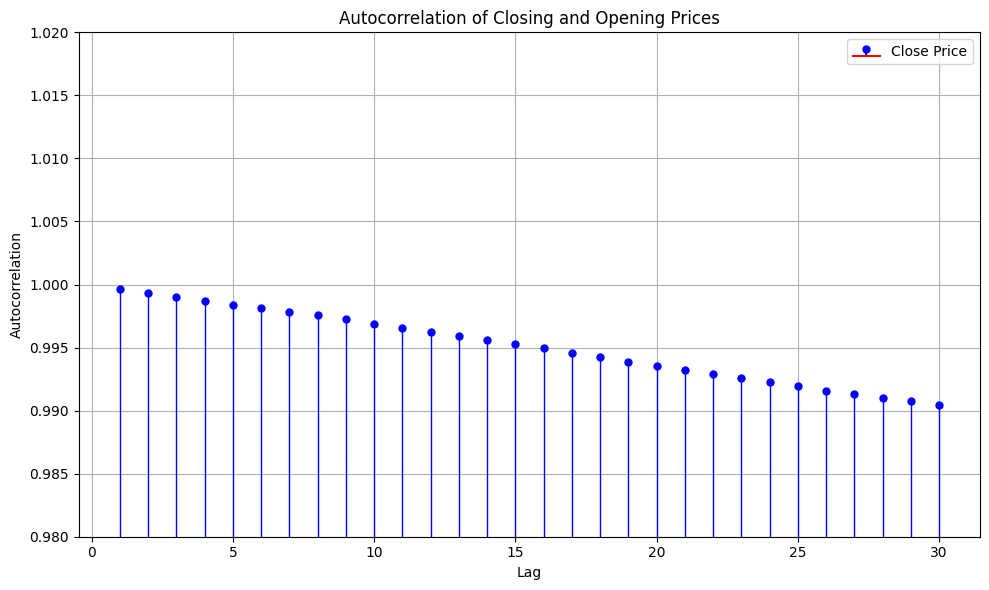

In [108]:
# Calculate autocorrelation for different lags
lags = range(1, 31)
autocorr_close = [df['close'].autocorr(lag=lag) for lag in lags]

# Autocorrelation plot
plt.figure(figsize=(10, 6))

# Plot autocorrelation for Closing Prices
(markerline_close, stemlines_close, baseline_close) = plt.stem(lags, autocorr_close, linefmt='b-', markerfmt='bo', basefmt='r-', label='Close Price')
plt.setp(markerline_close, markersize=5)
plt.setp(stemlines_close, linewidth=1, color='b')


plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Closing and Opening Prices')
plt.ylim(0.98, 1.02)
plt.legend(['Close Price'])
plt.grid(True)
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

Splitting data ensures that we can validate the model's ability to generalize to unseen data.

In [31]:
# Split data into training, validation, and test sets
def split_data(df, target_col="close"):
    y = df[target_col]
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
    return df_train, df_val, df_test

# Split data
df_train, df_val, df_test = split_data(df)

In [32]:
# Prepare features using DictVectorizer
def prepare_features(df, dv=None, fit_dv=True):
    dicts = df.to_dict(orient='records')
    if fit_dv:

        dv = DictVectorizer(sparse=False)
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
    return X, dv

# Prepare features
drop_columns = ['close', 'date', 'id']
df_train_features = df_train.drop(columns=drop_columns).reset_index(drop=True)
df_val_features = df_val.drop(columns=drop_columns).reset_index(drop=True)
df_test_features = df_test.drop(columns=drop_columns).reset_index(drop=True)

y_train = df_train['close'].values
y_val = df_val['close'].values
y_test = df_test['close'].values

# X_train, dv = prepare_features(df_train_features)
# X_val, _ = prepare_features(df_val_features, dv, fit_dv=False)
# X_test, _ = prepare_features(df_test_features, dv, fit_dv=False)

X_train = df_train_features.values
X_val = df_val_features.values
X_test = df_test_features.values

/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 RMSE: 3.0612
Fold 2 RMSE: 5.1376


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 RMSE: 6.2557
Fold 4 RMSE: 19.4433


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 RMSE: 0.9287
Średni RMSE: 6.9653


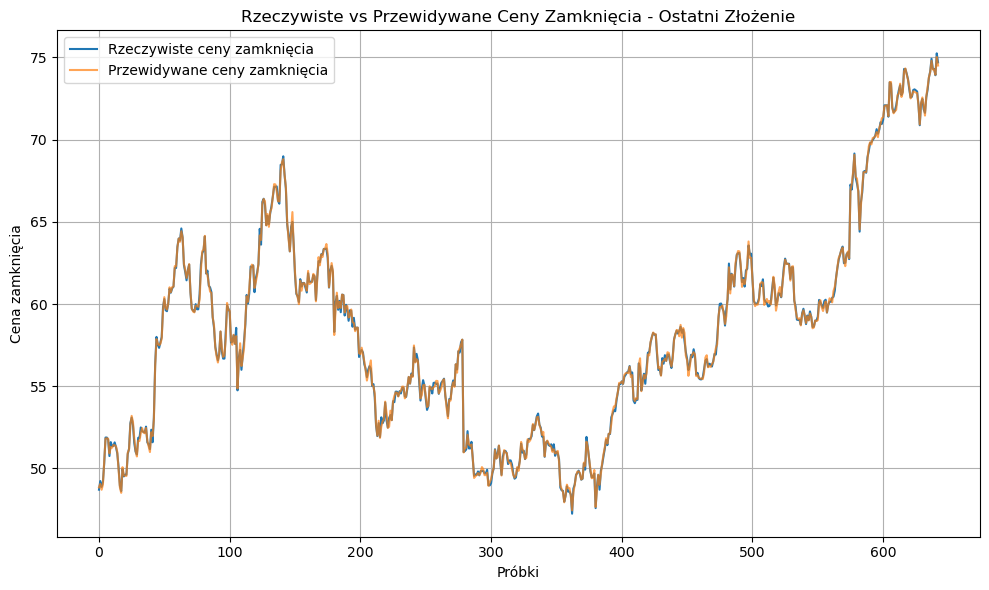

In [ ]:
# import pandas as pd
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error
# import xgboost as xgb
# import pickle
# import matplotlib.pyplot as plt

# # Przygotowanie danych
# drop_columns = ['close', 'date', 'id']
# df_features = df.drop(columns=drop_columns).reset_index(drop=True)
# y = df['close'].values

# # Skalowanie cech
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_features)

# # Zapisanie skalera
# with open('scaler.bin', 'wb') as f_out:
#     pickle.dump(scaler, f_out)

# # Inicjalizacja modelu XGBoost
# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=5,
#     random_state=1
# )

# # Inicjalizacja TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)

# # Lista do przechowywania RMSE dla każdego złożenia
# rmse_folds = []

# # Trenowanie i testowanie modelu na każdym złożeniu
# for fold, (train_index, test_index) in enumerate(tscv.split(X_scaled), 1):
#     X_tr, X_te = X_scaled[train_index], X_scaled[test_index]
#     y_tr, y_te = y[train_index], y[test_index]
    
#     # Trenowanie modelu
#     xgb_model.fit(X_tr, y_tr)
    
#     # Predykcja
#     y_pred = xgb_model.predict(X_te)
    
#     # Obliczanie RMSE
#     rmse = mean_squared_error(y_te, y_pred, squared=False)
#     rmse_folds.append(rmse)
    
#     print(f"Fold {fold} RMSE: {rmse:.4f}")

# # Obliczenie średniego RMSE
# average_rmse = sum(rmse_folds) / len(rmse_folds)
# print(f"Średni RMSE: {average_rmse:.4f}")

# # Trenowanie modelu na całym zbiorze danych
# xgb_model.fit(X_scaled, y)

# # Zapisanie modelu
# with open('xgb_model.bin', 'wb') as f_out:
#     pickle.dump(xgb_model, f_out)

# ### Dodatkowe Krok - Wizualizacja Wyników dla Ostatniego Złożenia

# # Predykcje na ostatnim złożeniu
# y_pred_last = xgb_model.predict(X_te)

# # Wizualizacja rzeczywistych vs przewidywanych wartości
# plt.figure(figsize=(10, 6))
# plt.plot(y_te, label='Rzeczywiste ceny zamknięcia')
# plt.plot(y_pred_last, label='Przewidywane ceny zamknięcia', alpha=0.7)
# plt.xlabel('Próbki')
# plt.ylabel('Cena zamknięcia')
# plt.title('Rzeczywiste vs Przewidywane Ceny Zamknięcia - Ostatni Złożenie')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt

def preprocess_data(df, drop_columns, training_columns, date_column='date'):
    """
    Prepares the data by sorting by date, removing unnecessary columns,
    and selecting training columns.

    :param df: DataFrame containing the data.
    :param drop_columns: List of columns to drop.
    :param training_columns: List of columns used as training features.
    :param date_column: Name of the date column.
    :return: DataFrame with processed features and target variable y.
    """
    # Sorting data by date
    df_sorted = df.sort_values(by=date_column).reset_index(drop=True)
    
    # Dropping unnecessary columns
    df_features = df_sorted.drop(columns=drop_columns).reset_index(drop=True)
    
    # Selecting target variable
    y = df_sorted['close'].values
    print(training_columns)
    # Selecting training columns
    X = df_features[training_columns]
    
    # Handling missing values
    X = X.fillna(method='ffill').fillna(method='bfill')
    
    return X, y

def scale_features(X, scaler_path='scaler.bin'):
    """
    Scales features using StandardScaler and saves the scaler.

    :param X: DataFrame containing the features.
    :param scaler_path: Path to save the scaler.
    :return: Scaled features as a numpy array.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Saving the scaler
    with open(scaler_path, 'wb') as f_out:
        pickle.dump(scaler, f_out)
    
    return X_scaled

def time_series_cv_train(X, y, n_splits=5, model_params=None):
    """
    Trains an XGBoost model using TimeSeriesSplit and evaluates RMSE for each split.

    :param X: Scaled training features.
    :param y: Target variable.
    :param n_splits: Number of splits for TimeSeriesSplit.
    :param model_params: Dictionary of XGBoost model parameters.
    :return: Trained model, list of RMSE for each split, and the last test set's true and predicted values.
    """
    if model_params is None:
        model_params = {
            'objective': 'reg:squarederror',
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 20,
            'random_state': 1
        }
    
    # Initializing the XGBoost model
    xgb_model = xgb.XGBRegressor(**model_params)
    
    # Initializing TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # List to store RMSE for each split
    rmse_folds = []
    
    # Training and testing the model on each split
    for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        
        # Training the model
        xgb_model.fit(X_tr, y_tr)
        
        # Prediction
        y_pred = xgb_model.predict(X_te)
        
        # Calculating RMSE
        rmse = mean_squared_error(y_te, y_pred, squared=False)
        rmse_folds.append(rmse)
        
        print(f"Fold {fold} RMSE: {rmse:.4f}")
    
    # Calculating average RMSE
    average_rmse = sum(rmse_folds) / len(rmse_folds)
    print(f"Average RMSE: {average_rmse:.4f}")
    
    return xgb_model, rmse_folds, y_te, y_pred

def train_final_model(X, y, model_path='xgb_model.bin'):
    """
    Trains the model on the entire dataset and saves the model.

    :param X: Scaled training features.
    :param y: Target variable.
    :param model_path: Path to save the model.
    :return: Trained model.
    """
    # Initializing the XGBoost model
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=1
    )
    
    # Training the model on the entire dataset
    xgb_model.fit(X, y)
    
    # Saving the model
    with open(model_path, 'wb') as f_out:
        pickle.dump(xgb_model, f_out)
    
    return xgb_model

def plot_predictions(y_true, y_pred, title='Actual vs Predicted Closing Prices - Last Split'):
    """
    Visualizes actual and predicted values.

    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :param title: Title of the plot.
    """
    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Closing Prices', marker='o')
    plt.plot(y_pred, label='Predicted Closing Prices', marker='x', alpha=0.7)
    plt.xlabel('Samples')
    plt.ylabel('Closing Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_errors(y_true, y_pred, title='Prediction Errors on Last Split'):
    """
    Visualizes prediction errors.

    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :param title: Title of the plot.
    """
    errors = y_pred - y_true
    
    plt.figure(figsize=(10, 4))
    plt.plot(errors, label='Prediction Error', color='red', marker='o')
    plt.xlabel('Samples')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 RMSE: 0.5002


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 RMSE: 0.3922


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 RMSE: 0.3345


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 RMSE: 0.3221


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 RMSE: 0.3267
Average RMSE: 0.3751


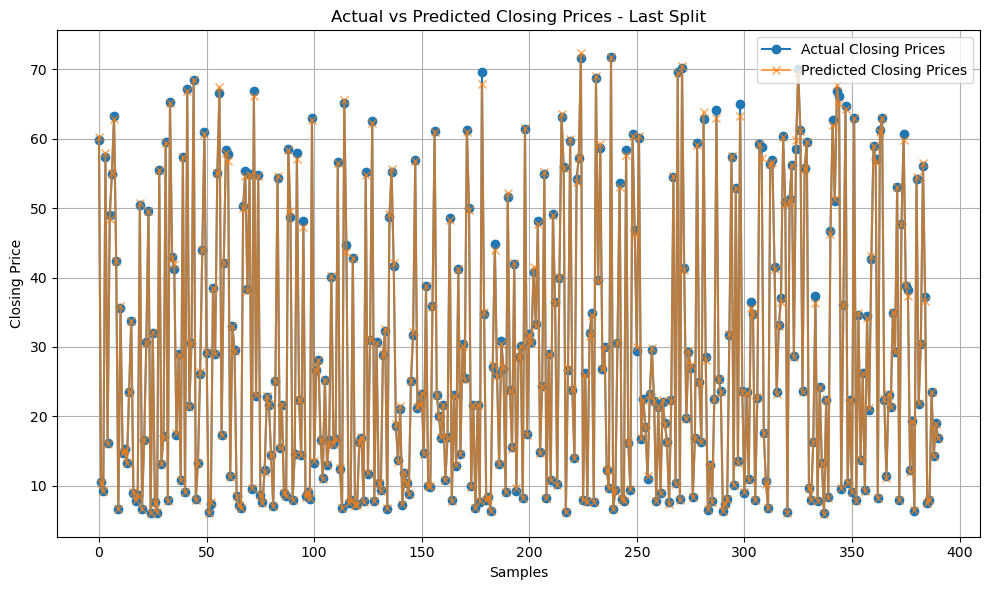

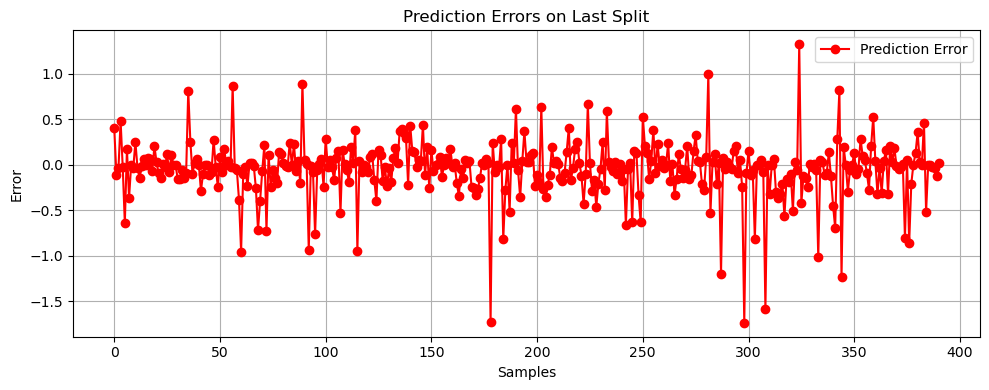

In [ ]:

# Define columns
# drop_columns = ['close', 'date', 'id']
training_columns = [
    'close_lag1', 'close_lag2', 'close_lag3', 'close_lag5', 'open', 'high', 'low', 
    'volume', 'interestrate', 'exchangerate', 'vix', 'tedspread', 'effr', 'gold', 
    'oil'
]

# Preprocess data
# X, y = preprocess_data(df_train, drop_columns, training_columns, date_column='date')
X = X_train
y = y_train
# Scale features
X_scaled = scale_features(X, scaler_path='scaler.bin')

# Train model with TimeSeriesSplit cross-validation
xgb_model, rmse_folds, y_te, y_pred = time_series_cv_train(X_scaled, y, n_splits=5)

# Train final model on the entire dataset
final_model = train_final_model(X_scaled, y, model_path='xgb_model.bin')

# Visualize results for the last split
plot_predictions(y_te, y_pred, title='Actual vs Predicted Closing Prices - Last Split')
plot_errors(y_te, y_pred, title='Prediction Errors on Last Split')

In [ ]:
# import pickle
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# import xgboost as xgb

# # Załaduj skalera
# with open('scaler.bin', 'rb') as f_in:
#     scaler2 = pickle.load(f_in)

# # Załaduj model
# with open('xgb_model.bin', 'rb') as f_in:
#     xgb_model = pickle.load(f_in)

# # # Przygotowanie danych (dopasuj do swoich danych)
# # drop_columns = ['close', 'date', 'id']  # Dostosuj w zależności od potrzeb
# # df_features = df.drop(columns=drop_columns, errors='ignore').reset_index(drop=True)

# # # Opcjonalnie: Upewnij się, że kolumny są w odpowiedniej kolejności
# # training_columns = ['close_lag1', 'close_lag2', 'close_lag3', 'close_lag5', 'open', 'high', 'low', 
# #                     'volume', 'interestrate', 'exchangerate', 'vix', 'tedspread', 'effr', 'gold', 
# #                     'oil', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'bollinger_high', 
# #                     'bollinger_low', 'bollinger_middle', 'ma_10', 'ma_50', 'stochastic', 
# #                     'stochastic_signal', 'atr']
# # df_features = df_features[training_columns]

# # Obsługa brakujących wartości (jeśli występują)
# drop_columns = ['close', 'date', 'id']
# df_train_features = df_train.drop(columns=drop_columns).reset_index(drop=True)
# df_val_features = df_val.drop(columns=drop_columns).reset_index(drop=True)
# df_test_features = df_test.drop(columns=drop_columns).reset_index(drop=True)

# y_train = df_train['close'].values
# y_val = df_val['close'].values
# y_test = df_test['close'].values

# # X_train, dv = prepare_features(df_train_features)
# # X_val, _ = prepare_features(df_val_features, dv, fit_dv=False)
# # X_test, _ = prepare_features(df_test_features, dv, fit_dv=False)

# X_train = df_train_features.values
# X_val = df_val_features.values
# X_test = df_test_features.values
# # print(df_train_features.iloc[0:1])
# # df_test_features.iloc[0:1]
# # # Skalowanie danych przy użyciu już dopasowanego skalera
# sample_index = 3
# X_scaled_sample = scaler2.transform(df_test_features.iloc[sample_index:sample_index+1])
# y_pred_sample = xgb_model.predict(X_scaled_sample)
# print(f"Przewidywana wartość: {y_pred_sample[0]:.4f} dla true value {y_test[sample_index]:.4f}")

# # # Wyświetlenie pierwszej predykcji
# # print(f"Przewidywana wartość: {y_pred[1]:.4f} dla true value {y_test[1]:.4f} i słownika \n{df_test.iloc[1:2].T}")

# # data = df_test.iloc[0:1].T
# # print(data)
# # # Set display precision and padding
# # for index, row in data.iterrows():
# #     formatted_values = " | ".join([f"{value:0.4f}".rjust(10) for value in row.values])
# #     print(f"{index:<15}: {formatted_values}")

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Załaduj skalera
with open('scaler.bin', 'rb') as f_in:
    scaler2 = pickle.load(f_in)

# Załaduj model
with open('xgb_model.bin', 'rb') as f_in:
    xgb_model = pickle.load(f_in)

# Przygotowanie danych testowych
drop_columns = ['close', 'date', 'id']  # Dostosuj w zależności od potrzeb
df_test_features = df_test.drop(columns=drop_columns).reset_index(drop=True)

# Upewnij się, że kolumny są w tej samej kolejności co podczas trenowania
# training_columns = [
#     'close_lag1', 'close_lag2', 'close_lag3', 'close_lag5', 'open', 'high', 'low', 
#     'volume', 'interestrate', 'exchangerate', 'vix', 'tedspread', 'effr', 'gold', 
#     'oil', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'bollinger_high', 
#     'bollinger_low', 'bollinger_middle', 'ma_10', 'ma_50', 'stochastic', 
#     'stochastic_signal', 'atr'
# ]
# df_test_features = df_test_features[training_columns]

# Obsługa brakujących wartości (jeśli występują)
df_test_features = df_test_features.fillna(method='ffill').fillna(method='bfill')



# Skalowanie danych przy użyciu już dopasowanego skalera
X_scaled = scaler2.transform(df_test_features)

# Predykcje na zbiorze testowym
y_pred = xgb_model.predict(X_scaled)

# Wyświetlenie przykładowych predykcji (pierwsze 4 próbki)
for i in range(4):
    print(f"Przewidywana wartość: {y_pred[i]:.4f} dla true value {y_test[i]:.4f}")

# Obliczanie RMSE dla zbioru testowego
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse_test:.4f}")

# Wizualizacja rzeczywistych vs przewidywanych wartości
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Rzeczywiste wartości', marker='o')
plt.plot(y_pred, label='Przewidywane wartości', marker='x', alpha=0.7)
plt.xlabel('Próbki')
plt.ylabel('Cena zamknięcia')
plt.title('Rzeczywiste vs Przewidywane Ceny Zamknięcia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wizualizacja błędów predykcji
errors = y_pred - y_test

plt.figure(figsize=(12, 4))
plt.plot(errors, label='Błąd predykcji', color='red')
plt.xlabel('Próbki')
plt.ylabel('Błąd')
plt.title('Błąd Predykcji na Zbiorze Testowym')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/gp/j593vlkj0jjbz68g1hsn82wh0000gn/T/ipykernel_3539/1804023041.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test_features = df_test_features.fillna(method='ffill').fillna(method='bfill')


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
test = df_test_features.iloc[0:1]

with open('scaler.bin', 'rb') as f_in:
    scaler2 = pickle.load(f_in)

# Załaduj model
with open('xgb_model.bin', 'rb') as f_in:
    xgb_model = pickle.load(f_in)

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Definiowanie liczby próbek do wyświetlenia
NUM_SAMPLES = 100

# Upewnienie się, że liczba próbek nie przekracza dostępnych danych
if len(y_test) < NUM_SAMPLES:
    NUM_SAMPLES = len(y_test)

# Predykcje na zbiorze testowym
y_pred = xgb_model.predict(X_scaled)

# Wyświetlenie przykładowych predykcji (pierwsze 100 próbek)
for i in range(NUM_SAMPLES):
    print(f"Przewidywana wartość: {y_pred[i]:.4f} dla true value {y_test[i]:.4f}")

# Obliczanie RMSE dla zbioru testowego
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse_test:.4f}")

# Wizualizacja rzeczywistych vs przewidywanych wartości dla pierwszych 100 próbek
plt.figure(figsize=(12, 6))
plt.plot(range(NUM_SAMPLES), y_test[:NUM_SAMPLES], label='Rzeczywiste wartości', marker='o')
plt.plot(range(NUM_SAMPLES), y_pred[:NUM_SAMPLES], label='Przewidywane wartości', marker='x', alpha=0.7)
plt.xlabel('Próbki')
plt.ylabel('Cena zamknięcia')
plt.title('Rzeczywiste vs Przewidywane Ceny Zamknięcia (100 próbek)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wizualizacja błędów predykcji dla pierwszych 100 próbek
errors = y_pred[:NUM_SAMPLES] - y_test[:NUM_SAMPLES]

plt.figure(figsize=(12, 4))
plt.plot(range(NUM_SAMPLES), errors, label='Błąd predykcji', color='red')
plt.xlabel('Próbki')
plt.ylabel('Błąd')
plt.title('Błąd Predykcji na Zbiorze Testowym (100 próbek)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Przewidywana wartość: 60.7261 dla true value 59.2867
Przewidywana wartość: 21.5430 dla true value 14.5400
Przewidywana wartość: 35.5621 dla true value 10.3967
Przewidywana wartość: 8.2625 dla true value 20.5700
Przewidywana wartość: 62.2751 dla true value 60.5500
Przewidywana wartość: 21.8931 dla true value 22.3733
Przewidywana wartość: 55.9232 dla true value 7.7500
Przewidywana wartość: 17.0348 dla true value 9.3333
Przewidywana wartość: 8.3353 dla true value 57.4933
Przewidywana wartość: 66.1085 dla true value 34.5300
Przewidywana wartość: 35.9991 dla true value 65.9933
Przewidywana wartość: 7.5237 dla true value 7.3533
Przewidywana wartość: 26.4229 dla true value 17.1100
Przewidywana wartość: 30.1025 dla true value 23.8367
Przewidywana wartość: 14.6847 dla true value 30.6300
Przewidywana wartość: 12.7351 dla true value 12.6333
Przewidywana wartość: 14.4648 dla true value 33.5600
Przewidywana wartość: 8.5340 dla true value 59.5167
Przewidywana wartość: 13.1951 dla true value 16.6400


ValueError: Found input variables with inconsistent numbers of samples: [783, 2348]

In [36]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Załaduj skalera
with open('scaler.bin', 'rb') as f_in:
    scaler2 = pickle.load(f_in)

# Załaduj model
with open('xgb_model.bin', 'rb') as f_in:
    xgb_model = pickle.load(f_in)

# Definicja listy kolumn używanych podczas trenowania
training_columns = [
    'close_lag1', 'close_lag2', 'close_lag3', 'close_lag5', 'open', 'high', 'low', 
    'volume', 'interestrate', 'exchangerate', 'vix', 'tedspread', 'effr', 'gold', 
    'oil', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'bollinger_high', 
    'bollinger_low', 'bollinger_middle', 'ma_10', 'ma_50', 'stochastic', 
    'stochastic_signal', 'atr'
]

training_columns = [
    'open', 'high', 'low', 
    'volume', 'interestrate', 'exchangerate', 'vix', 'tedspread', 'effr', 'gold', 
    'oil'
]

# Definicja przykładowych danych jako słownik
sample_data ={
    'open': 151.00,
    'high': 152.00,
    'low': 149.50,
    'volume': 1200000,
    'interestrate': 0.5,
    'exchangerate': 1.2,
    'vix': 20.5,
    'tedspread': 100.0,
    'effr': 0.25,
    'gold': 1800.75,
    'oil': 70.50
}


# Konwersja słownika do DataFrame
sample_df = pd.DataFrame([sample_data])

# Sprawdzenie, czy wszystkie wymagane kolumny są obecne
missing_cols = set(training_columns) - set(sample_df.columns)
extra_cols = set(sample_df.columns) - set(training_columns)

if missing_cols:
    raise ValueError(f"Brakujące kolumny w danych wejściowych: {missing_cols}")
if extra_cols:
    print(f"Uwaga: Dodatkowe kolumny zostaną pominięte: {extra_cols}")

# Uporządkowanie kolumn zgodnie z training_columns
sample_df = sample_df[training_columns]

# Obsługa brakujących wartości (jeśli występują)
sample_df = sample_df.fillna(method='ffill').fillna(method='bfill')

# Skalowanie danych przy użyciu już dopasowanego skalera
X_scaled_sample = scaler2.transform(sample_df)

# Predykcja
y_pred_sample = xgb_model.predict(X_scaled_sample)

# Wyświetlenie wyniku
print(f"Przewidywana wartość: {y_pred_sample[0]:.4f}")

Przewidywana wartość: 73.1739


/var/folders/gp/j593vlkj0jjbz68g1hsn82wh0000gn/T/ipykernel_3539/1701995913.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sample_df = sample_df.fillna(method='ffill').fillna(method='bfill')
/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## Prepare Features

We need to prepare the data for modeling, transforming it into the appropriate format.

In [30]:
# Prepare features using DictVectorizer
def prepare_features(df, dv=None, fit_dv=True):
    dicts = df.to_dict(orient='records')
    if fit_dv:

        dv = DictVectorizer(sparse=False)
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
    return X, dv

# Prepare features
drop_columns = ['close', 'date', 'id']
df_train_features = df_train.drop(columns=drop_columns).reset_index(drop=True)
df_val_features = df_val.drop(columns=drop_columns).reset_index(drop=True)
df_test_features = df_test.drop(columns=drop_columns).reset_index(drop=True)

y_train = df_train['close'].values
y_val = df_val['close'].values
y_test = df_test['close'].values

# X_train, dv = prepare_features(df_train_features)
# X_val, _ = prepare_features(df_val_features, dv, fit_dv=False)
# X_test, _ = prepare_features(df_test_features, dv, fit_dv=False)

X_train = df_train_features.values
X_val = df_val_features.values
X_test = df_test_features.values

## Hyperparameter Tuning with Grid Search
Hyperparameters are parameters whose values are set before the learning process begins. Grid Search exhaustively searches through a specified parameter grid.

In [138]:
# Tune hyperparameters using Grid Search
def grid_search_tuning(X_train, y_train, param_grid):
    rf = RandomForestRegressor(random_state=1, n_jobs=-1)
    grid_search = GridSearchCV(
        rf, param_grid, cv=3, scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)
    return grid_search.best_estimator_

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# Hyperparameter tuning
best_model = grid_search_tuning(X_train, y_train, param_grid)

Best parameters: {'max_depth': 10, 'n_estimators': 50}
Best RMSE: 0.2919493672937388


In [97]:
def train_and_evaluate_model(X_train, y_train, X_val, y_val):
    rf = RandomForestRegressor(random_state=1, n_jobs=-1)
    param_distributions = {
        'n_estimators': np.arange(100, 501, 100),
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    random_search = RandomizedSearchCV(
        rf, param_distributions, n_iter=20, cv=3, scoring='neg_root_mean_squared_error', random_state=1, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    print("Najlepsze parametry:", random_search.best_params_)
    print("Najlepszy RMSE (CV):", -random_search.best_score_)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"Walidacyjny RMSE: {rmse:.2f}")

    # Wykres ważności cech
    feature_importances = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    # plt.figure(figsize=(10, 8))
    # # plt.barh(np.array(dv.get_feature_names_out())[sorted_idx], feature_importances[sorted_idx])
    # plt.xlabel("Ważność cechy")
    # plt.title("Ważność cech w RandomForestRegressor")
    # plt.show()

    return best_model

In [98]:
best_model = train_and_evaluate_model(X_train, y_train, X_val, y_val)

Najlepsze parametry: {'n_estimators': np.int64(400), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30}
Najlepszy RMSE (CV): 0.27632038081179616
Walidacyjny RMSE: 0.26


/Users/rafalszulinski/Desktop/developing/ml-zoomcamp-2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
# dt = DecisionTreeRegressor(max_depth=1)
# dt.fit(X_train, y_train)

# val_dict = df_val.to_dict(orient='records')

# X_val = scaler.transform(val_dict)
# y_pred = dt.predict(X_val)

# mapped_dict = {i: (val, pred) for i, (val, pred) in enumerate(zip(y_val, y_pred))}

ValueError: Number of labels=2348 does not match number of samples=3131

In [ ]:
print(export_text(dt, feature_names=scaler.get_feature_names_out()))

import numpy as np

# Zakładając, że dt jest wytrenowanym modelem DecisionTreeRegressor
# i dv jest instancją DictVectorizer

# Uzyskaj znaczenie cech
feature_importances = dt.feature_importances_

# Znajdź indeks cechy z najwyższą wartością znaczenia
most_important_index = np.argmax(feature_importances)

# Uzyskaj nazwę najważniejszej cechy
feature_names = dv.get_feature_names_out()
most_important_feature = feature_names[most_important_index]

# Wyświetl najważniejszą cechę
print(f'Most important feature: {most_important_feature}')

AttributeError: 'DecisionTreeRegressor' object has no attribute 'tree_'

In [109]:
from sklearn.ensemble import RandomForestRegressor

In [110]:
n_estimators=200
random_state=1
n_jobs=-1

In [114]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    # dv = DictVectorizer(sparse=False)
    # X_train = dv.fit_transform(dicts)
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model.fit(df_train, y_train)

    
    return model

In [77]:
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs) 
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_pred, y_val, squared=False)

print("%.2f" % rmse)

0.26


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [78]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    rmse = mean_squared_error(y_pred, y_val, squared=False)

    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

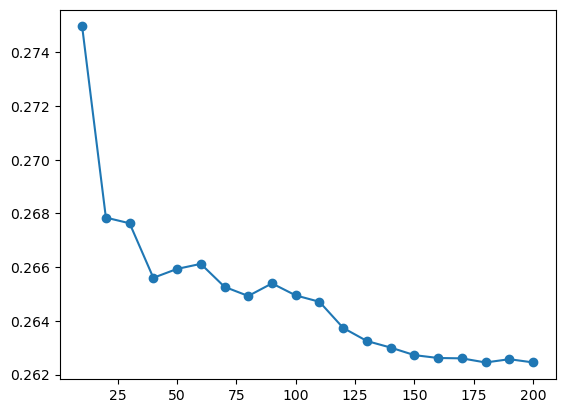

In [79]:
plt.plot(df_scores.n_estimators, df_scores.rmse, marker='o')

In [115]:
model = train(df_train, y_train, C=1.0)

In [116]:
df_train.head()

,open,high,low,volume,interestrate,exchangerate,vix,tedspread,effr,gold,oil
0,62.0500,62.0500,60.0600,1959500.0000,5.3300,1.0879,12.9200,0.0900,5.3300,2355.2000,79.8300
1,21.4267,21.6367,21.4067,1980300.0000,0.3800,1.1158,19.3700,0.3800,0.3800,1296.1000,46.2100
2,35.4233,35.9633,35.3300,1590000.0000,1.5500,1.1106,12.5400,0.3400,1.5500,1551.7000,59.5600
3,8.2967,8.3500,8.2300,6941100.0000,0.1400,1.3104,20.0200,0.3800,0.1600,1659.0000,102.7000
4,62.0300,62.8267,61.8900,2205900.0000,0.1000,1.1761,17.2000,0.0800,0.1000,1801.4000,72.0700


In [117]:
model.feature_importances_

array([3.04859007e-02, 2.90592375e-01, 6.78558719e-01, 1.21354372e-05,
       8.46313888e-05, 2.00061738e-05, 1.18282412e-05, 4.98399193e-06,
       2.72478717e-06, 4.26044115e-05, 1.84090953e-04])

In [119]:
df_train_full.columns

Index(['open', 'high', 'low', 'close', 'volume', 'interestrate',
       'exchangerate', 'vix', 'tedspread', 'effr', 'gold', 'oil'],
      dtype='object')

In [120]:
feat_importances = pd.DataFrame(
        model.feature_importances_, 
        index=df_train.columns, 
        columns=["Importance"]
    )

In [121]:
feat_importances

,Importance
open,0.0305
high,0.2906
low,0.6786
volume,0.0000
interestrate,0.0001
exchangerate,0.0000
vix,0.0000
tedspread,0.0000
effr,0.0000
gold,0.0000


In [82]:
y_train

array([60.20000076, 21.62999916, 35.78333282, ..., 14.25666714,
       19.07999992, 16.86666679])

In [127]:
df_test_features.iloc[0].to_dict()

{'open': 13.226667404174805,
 'high': 13.333333015441896,
 'low': 13.15999984741211,
 'volume': 2837100.0,
 'interestrate': 0.09,
 'exchangerate': 1.361,
 'vix': 10.32,
 'tedspread': 0.22,
 'effr': 0.09,
 'gold': 1320.4000244140625,
 'oil': 104.05999755859376,
 'rsi': 68.65693324213193,
 'macd': 0.20226160530399717,
 'macd_signal': 0.12954559059034498,
 'macd_diff': 0.07271601471365219,
 'bollinger_high': 13.268255172581977,
 'bollinger_low': 11.978411449579887,
 'bollinger_middle': 12.623333311080932,
 'ma_10': 12.85699987411499,
 'ma_50': 12.418933353424073,
 'stochastic': 98.35612615783289,
 'stochastic_signal': 97.5097637011416,
 'atr': 0.25396704813981985,
 'close_lag1': 13.216667175292969,
 'close_lag2': 13.109999656677246,
 'close_lag3': 12.873332977294922,
 'close_lag5': 12.673333168029783}

In [ ]:
y_test[0]

np.float64(61.349998474121094)

In [155]:
# client = {
#   "date": "2010-01-15",
#   "open": 6.6400,
#   "high": 6.8100,
#   "low": 6.6333,
#   "volume": 6514500.0000,
#   "interestrate": 0.1100,
#   "exchangerate": 1.4419,
#   "vix": 20.0400,
#   "tedspread": 0.1700,
#   "effr": 0.1200,
#   "gold": 1117.7000,
#   "oil": 81.5100,  
#   "dxy": 78.4300,
#   "close": 6.8000
  
# }
# client_df = pd.DataFrame([df_test_features.iloc[0].to_dict()])

# # Przetwarzanie kolumny 'date'
# client_df['date'] = pd.to_datetime(client_df['date'])
# client_df['day_of_week'] = client_df['date'].dt.dayofweek
# client_df['month'] = client_df['date'].dt.month
# client_df['quarter'] = client_df['date'].dt.quarter
# client_df = client_df.drop(columns=['date'])

# # Upewnienie się, że kolumny są w takiej samej kolejności jak w danych treningowych
# client_df = client_df[df_train_features.columns]
# X_client = dv.transform([client])
y_pred = best_model.predict(pd.DataFrame([df_test_features.iloc[32].to_dict()]))[0]
y_pred, y_test[32]

/Users/rafalszulinski/Desktop/developing/ml-zoomcamp-2024/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(np.float64(57.44382075809297), np.float64(57.04999923706055))

In [84]:
output_file = f'model_C.bin'


In [85]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

print(f'the model is saved to {output_file}')

the model is saved to model_C.bin


**Conclusion**
In this notebook, we:

Loaded and preprocessed stock market data.
Calculated various technical indicators to capture market trends and patterns.
Performed feature engineering, including adding lag features and technical indicators.
Split the data into training, validation, and test sets.
Tuned hyperparameters using Grid Search with cross-validation.
Trained a Random Forest regression model to predict closing prices.
Evaluated the model's performance and visualized important features.
Saved the trained model for future use.
Made a prediction for the next day's closing price using the latest data.

Finance Theory Integration:

Understanding technical indicators and their implications on stock price movements is crucial. Indicators like RSI, MACD, and Bollinger Bands help traders make informed decisions by analyzing historical data patterns. By incorporating these indicators into our model, we aim to capture the nuanced relationships between past market behavior and future price movements.

Next Steps:

This notebook provides a foundational approach to time series forecasting using traditional machine learning techniques. However, time series data often contains sequential dependencies and patterns that can be more effectively captured by specialized models like Long Short-Term Memory (LSTM) neural networks.

LSTM networks are capable of learning long-term dependencies and can model complex temporal dynamics inherent in stock price movements. Venturing into LSTM and other deep learning models could enhance prediction accuracy, especially for datasets with rich temporal features.